In [8]:
from sklearn.decomposition import PCA
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split 
from sklearn.decomposition import KernelPCA
from sklearn.kernel_approximation import Nystroem
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, r2_score


PCA

In [9]:
combined_df_no_nans = pd.read_parquet("/cluster/home/maikents/sinmod_features_masters/dataframes_pipeline_1/total_df_no_nans_and_labels.parquet")

In [10]:
combined_df = combined_df_no_nans.drop(columns=['x', 'y','labels'])

In [5]:
print(combined_df.columns)

Index(['bathymetry', 'slope', 'fine_BPI_std', 'broad_BPI_std',
       'log_ruggedness', 'aspect_cos', 'aspect_sin', 'temperature_min',
       'temperature_max', 'salinity_10th_percentile', 'salinity_mean',
       'salinity_90th_percentile', 'current_speed_mean',
       'current_speed_90th_percentile', 'statistical_northness',
       'statistical_eastness', 'current_aspect_angle', 'chlor_a_min',
       'chlor_a_mean', 'chlor_a_max'],
      dtype='object')


In [11]:
#Drop columns after correlation analysis
combined_df = combined_df.drop(columns=['log_ruggedness', 'temperature_max', 'salinity_10th_percentile',
                                       'salinity_90th_percentile', 'current_speed_90th_percentile'])

In [7]:
pca = PCA(n_components=0.95)
pca_result = pca.fit_transform(combined_df)

In [8]:
pca_df = pd.DataFrame(data=pca_result, columns=[f'PC{i+1}' for i in range(pca_result.shape[1])])

In [9]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 20.97%
PC1: 0.3565481716976357
PC2: 0.17652149147110408
PC3: 0.004695817566703279
PC4: 0.005501237665614909
PC5: -0.1159553737067386
PC6: 0.11631623277896173
PC7: -0.22193905131693337
PC8: 0.016145415647620065
PC9: 0.0036045349222203604


Principal Component 2: 14.14%
PC1: 0.2558659392976519
PC2: -0.012425749748760345
PC3: 0.630243755342462
PC4: 0.7071669385300464
PC5: -0.011967840501351653
PC6: 0.06146314204863874
PC7: -0.09831893051725761
PC8: 0.007744042669727433
PC9: 0.0010885837150071223


Principal Component 3: 13.81%
PC1: 0.11480324214975514
PC2: -0.08708459474070342
PC3: -0.057354496839609234
PC4: -0.04622276261294803
PC5: 0.5164045734482066
PC6: 0.491540101406162
PC7: -0.06832044157152274
PC8: 0.007690611658977774
PC9: 0.0007038989911482608


Principal Component 4: 12.10%
PC1: -0.3862300754699776
PC2: 0.4170611921639121
PC3: 0.18734451064776989
PC4: 0.14414273430571795
PC5: 0.47339117140061926
PC6: -0.32802605628881587
PC7: 0.42304867117632905
PC8: -0.03

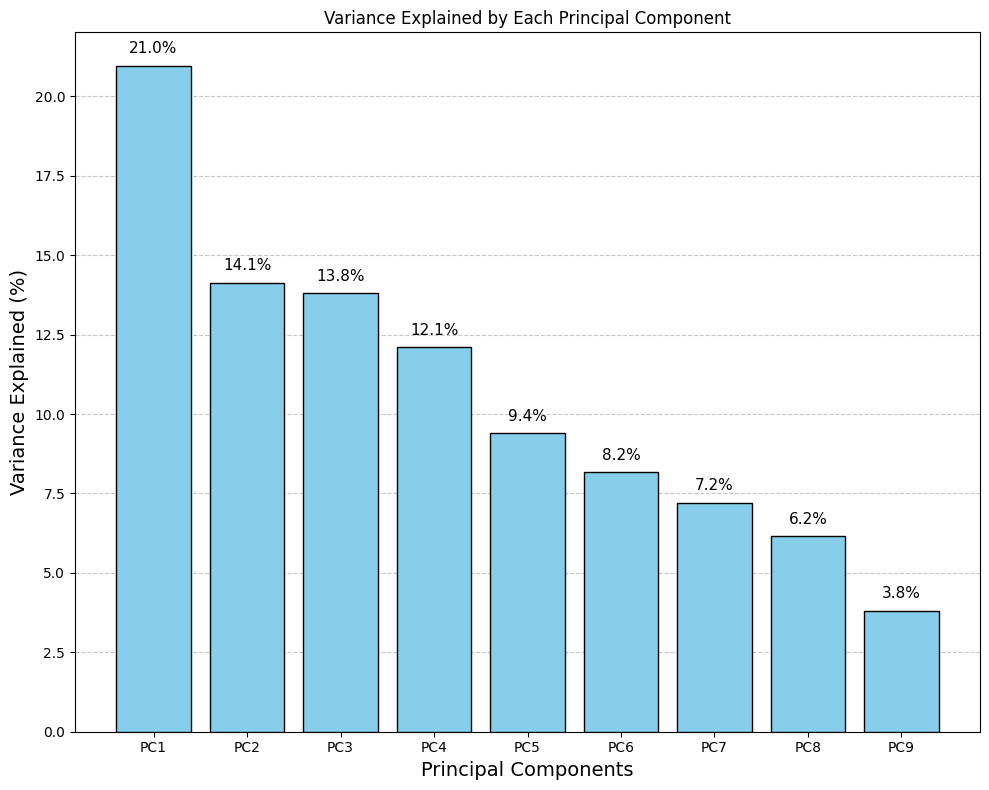

In [10]:
pca_variance = [20.97, 14.14, 13.81, 12.10, 9.40, 8.17, 7.21, 6.15, 3.80]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()


In [11]:
loadings = pca.components_.T 

loading_df = pd.DataFrame(loadings, index=combined_df.columns, 
                          columns=[f'PC{i+1}' for i in range(loadings.shape[1])])


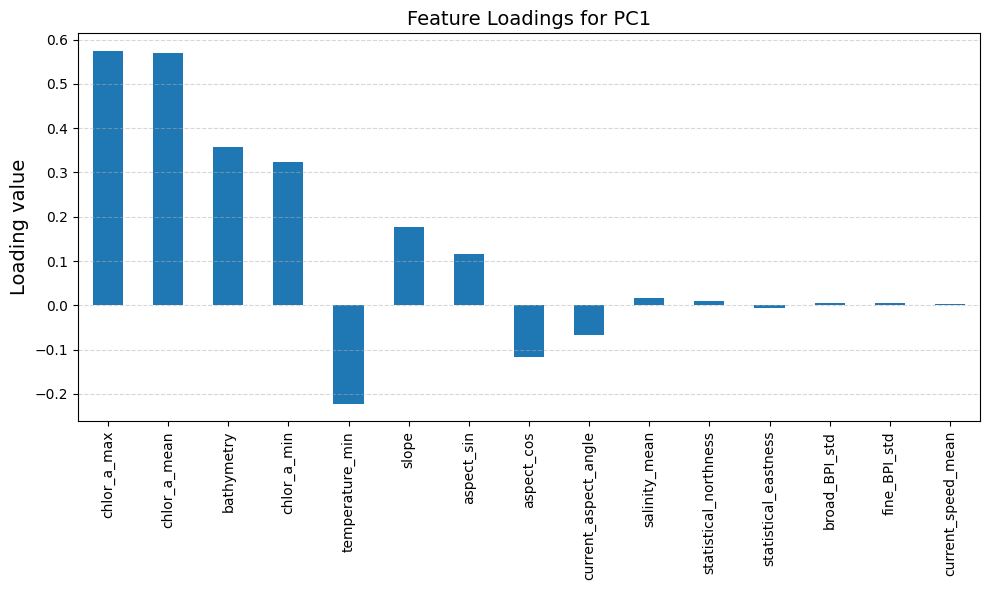

In [12]:
pc1_loadings = loading_df['PC1'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc1_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC1", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


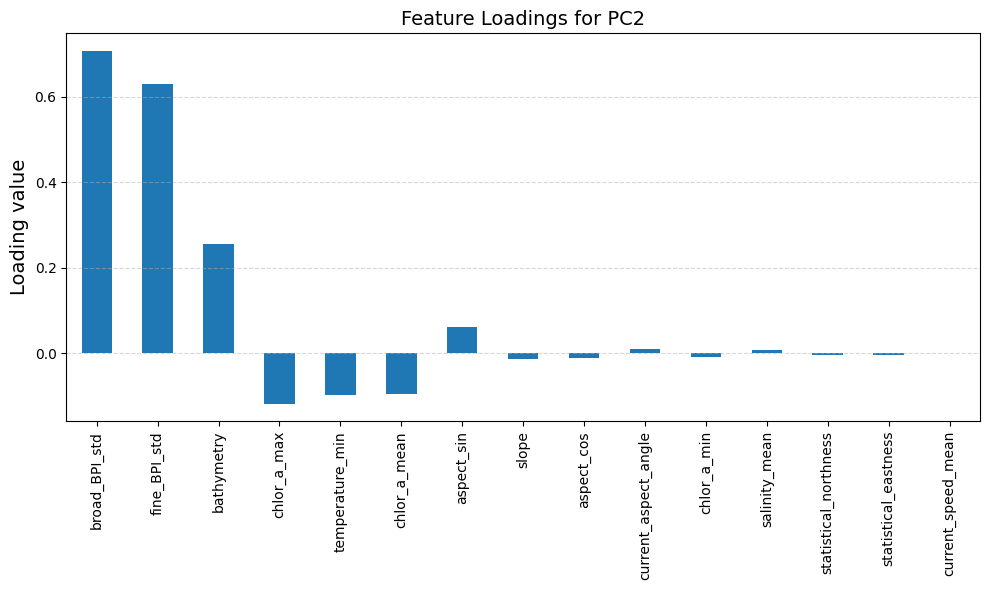

In [13]:
pc2_loadings = loading_df['PC2'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc2_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC2", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


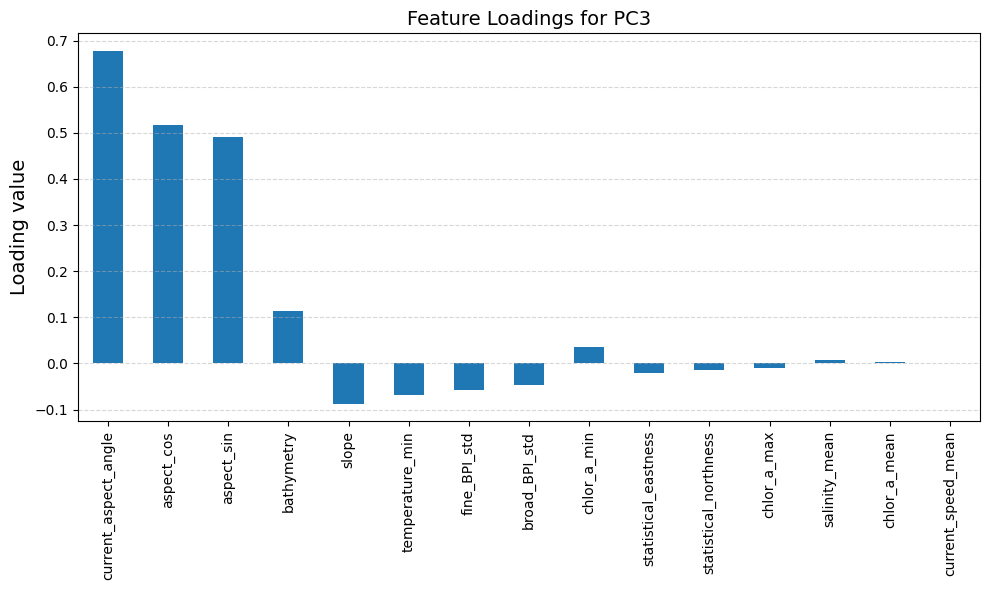

In [14]:
pc3_loadings = loading_df['PC3'].sort_values(key=abs, ascending=False)
plt.figure(figsize=(10,6))
pc3_loadings.plot(kind='bar')
plt.title("Feature Loadings for PC3", fontsize=14)
plt.ylabel("Loading value", fontsize=14)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


PLS

In [15]:
X = combined_df
y = combined_df_no_nans[['labels']]

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
pls = PLSRegression(n_components=2)
pls.fit(X_train, Y_train)

PLSRegression()

In [18]:
X_scores, Y_scores = pls.transform(X_train), pls.predict(X_train)

In [19]:
Y_train_pred = pls.predict(X_train)
Y_test_pred = pls.predict(X_test)

#Explained variance
print("X Loadings:", pls.x_loadings_)
print("Y Loadings:", pls.y_loadings_)

X Loadings: [[ 0.35614831  0.16229369]
 [ 0.29912784 -0.25317135]
 [ 0.17525116 -0.19100856]
 [ 0.15512308 -0.1119783 ]
 [-0.22228204  0.18555659]
 [ 0.00269594  0.23742758]
 [-0.38416279  0.11244227]
 [ 0.22666721  0.05456154]
 [ 0.20165475  0.09460886]
 [-0.05458374  0.19851782]
 [ 0.14794931 -0.43585737]
 [-0.05233159 -0.07183975]
 [ 0.40408734  0.36169337]
 [ 0.48139833  0.51882386]
 [ 0.42904798  0.47839703]]
Y Loadings: [[ 0.00347296 -0.0019247 ]]


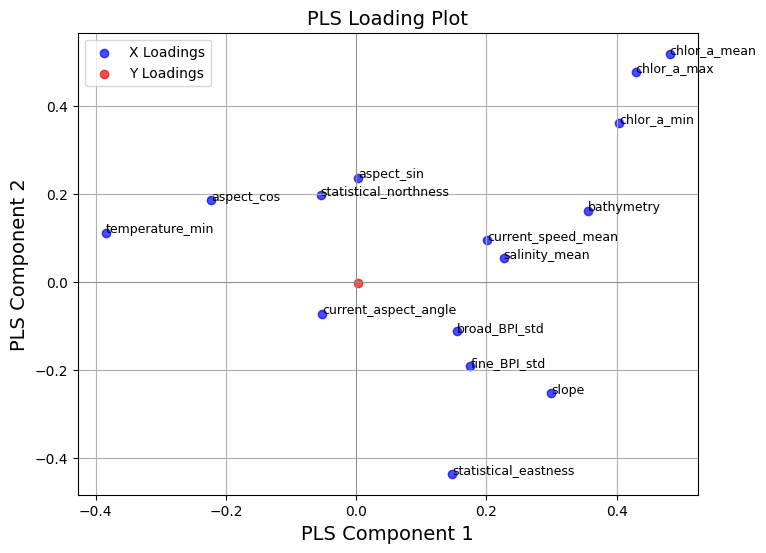

In [20]:
loadings_X = pls.x_loadings_
loadings_Y = pls.y_loadings_

plt.figure(figsize=(8, 6))
plt.scatter(loadings_X[:, 0], loadings_X[:, 1], label='X Loadings', color='blue', alpha=0.7)
plt.scatter(loadings_Y[:, 0], loadings_Y[:, 1], label='Y Loadings', color='red', alpha=0.7)

for i, feature in enumerate(X_train.columns):
    plt.text(loadings_X[i, 0], loadings_X[i, 1], feature, fontsize=9)

plt.axhline(0, color='gray', lw=0.5)
plt.axvline(0, color='gray', lw=0.5)
plt.xlabel("PLS Component 1", fontsize=14)
plt.ylabel("PLS Component 2", fontsize=14)
plt.title("PLS Loading Plot", fontsize=14)
plt.grid(True)
plt.legend()
plt.show()

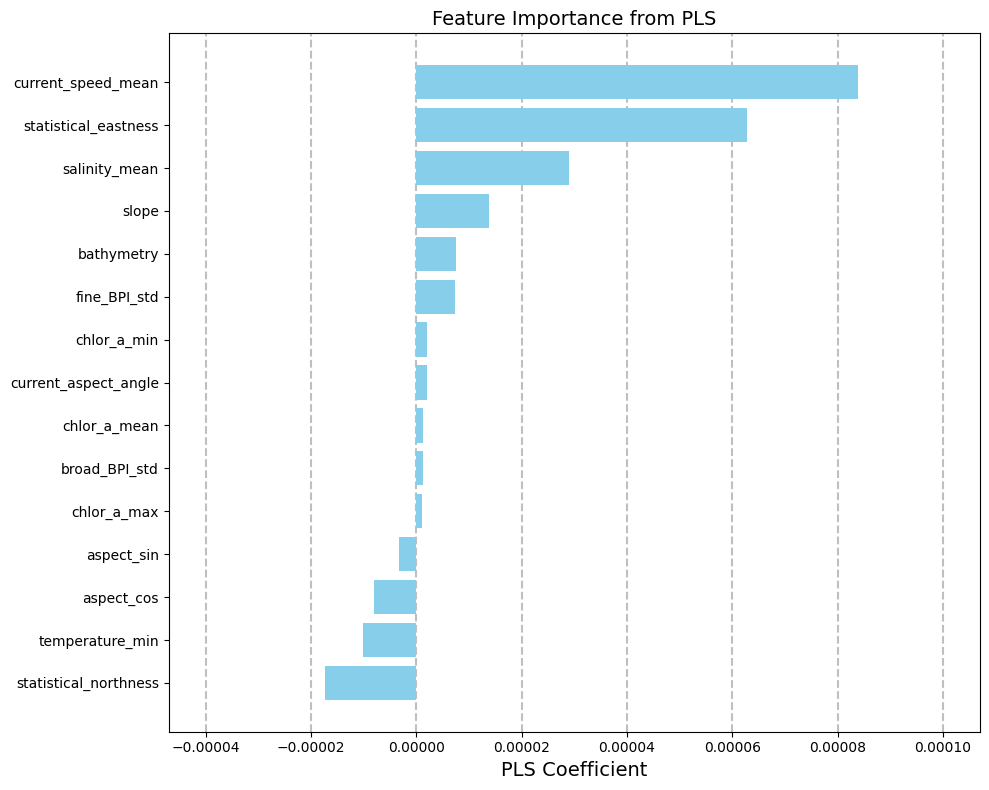

In [21]:
import matplotlib.pyplot as plt
import numpy as np

features = X.columns
coefficients = pls.coef_.ravel()

sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = features[sorted_indices]
sorted_coefficients = coefficients[sorted_indices]
plt.figure(figsize=(10, 8))
plt.barh(sorted_features, sorted_coefficients, color="skyblue")
xticks = plt.xticks()[0]
for x in xticks:
    plt.axvline(x=x, linestyle='--', color='gray', alpha=0.5, zorder=0)
plt.title("Feature Importance from PLS", fontsize=14)
plt.xlabel("PLS Coefficient", fontsize=14)
plt.gca().invert_yaxis()  
plt.tight_layout() 
plt.show()

Kernel PCA 

In [12]:
feature_map = Nystroem(kernel='rbf', gamma=0.1, n_components=50)
X_mapped = feature_map.fit_transform(combined_df)

pca = PCA(n_components=10)
#pca = PCA(n_components=0.95)
X_kpca_approx = pca.fit_transform(X_mapped)

In [13]:
pca_df = pd.DataFrame(data=X_kpca_approx, columns=[f'PC{i+1}' for i in range(X_kpca_approx.shape[1])])

In [14]:
for i in range(pca.n_components_):
    print(f"Principal Component {i + 1}: {pca.explained_variance_ratio_[i] * 100:.2f}%")
    for col_name in pca_df.columns:
        print(f"{col_name}: {pca.components_[i][pca_df.columns.get_loc(col_name)]}")

    print("\n")

Principal Component 1: 17.71%
PC1: -0.08991180958349226
PC2: -0.044759406646146416
PC3: -0.0002872419272758967
PC4: -0.12540256468724031
PC5: 0.1626454879944741
PC6: 0.01579721282096847
PC7: -0.1799042701892041
PC8: -0.13909947398420977
PC9: -0.11657076125846015
PC10: 0.04489184716370534


Principal Component 2: 16.96%
PC1: 0.17716796938398344
PC2: 0.16934655844825686
PC3: -0.0014596775842747127
PC4: -0.1345953093738967
PC5: -0.20454640818806627
PC6: 0.1097254448600806
PC7: 0.15848831292611937
PC8: -0.023895410881808386
PC9: 0.22047220011634086
PC10: -0.21457926522809154


Principal Component 3: 12.14%
PC1: 0.17841486776155113
PC2: 0.14074286443084866
PC3: -0.00851087619053468
PC4: -0.0935357821046039
PC5: 0.06392197336237329
PC6: -0.009902742669984026
PC7: 0.21091248936371956
PC8: -0.19781010722160133
PC9: 0.1663322216520096
PC10: 0.28158010930688326


Principal Component 4: 9.85%
PC1: -0.016397157385975317
PC2: -0.027864828204456703
PC3: -0.009104099136105367
PC4: 0.12930580323781687

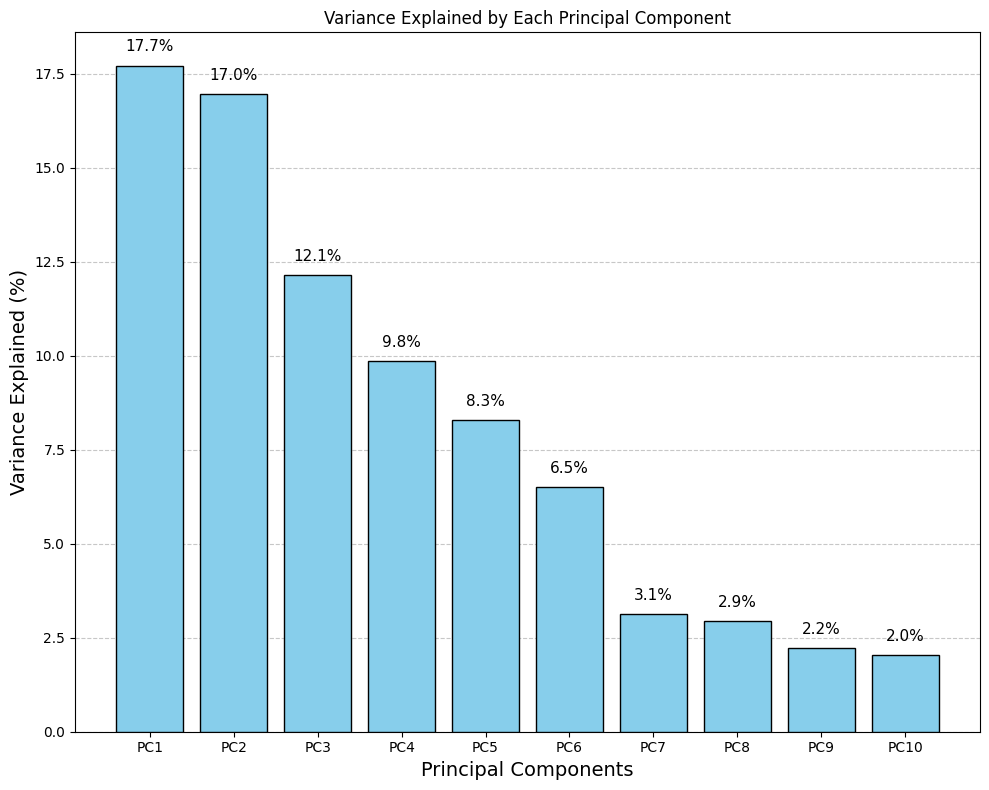

In [15]:
pca_variance = [17.71, 16.96, 12.14, 9.85, 8.28, 6.50, 3.12, 2.94, 2.23, 2.04]
components = [f'PC{i+1}' for i in range(len(pca_variance))]

plt.figure(figsize=(10, 8))
bars = plt.bar(components, pca_variance, color='skyblue', edgecolor='black')

plt.grid(axis='y', linestyle='--', alpha=0.7, zorder=0)

for bar in bars:
    bar.set_zorder(3)

plt.xlabel('Principal Components', fontsize=14)
plt.ylabel('Variance Explained (%)', fontsize=14)
plt.title('Variance Explained by Each Principal Component')

for i, v in enumerate(pca_variance):
    plt.text(i, v + 0.3, f"{v:.1f}%", ha='center', va='bottom', fontsize=11)

plt.tight_layout()
plt.savefig("PCA_variance_each_component_pipeline_1.png", dpi=300)

plt.show()